In [1]:
!pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

! mkdir data

! unzip /content/predict-energy-behavior-of-prosumers.zip -d data

Saving kaggle.json to kaggle.json
100% 232M/233M [00:11<00:00, 23.7MB/s]
100% 233M/233M [00:11<00:00, 21.3MB/s]
Archive:  /content/predict-energy-behavior-of-prosumers.zip
  inflating: data/client.csv         
  inflating: data/county_id_to_name_map.json  
  inflating: data/electricity_prices.csv  
  inflating: data/enefit/__init__.py  
  inflating: data/enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: data/example_test_files/client.csv  
  inflating: data/example_test_files/electricity_prices.csv  
  inflating: data/example_test_files/forecast_weather.csv  
  inflating: data/example_test_files/gas_prices.csv  
  inflating: data/example_test_files/historical_weather.csv  
  inflating: data/example_test_files/revealed_targets.csv  
  inflating: data/example_test_files/sample_submission.csv  
  inflating: data/example_test_files/test.csv  
  inflating: data/forecast_weather.csv  
  inflating: data/gas_prices.csv     
  inflating: data/historical_weather.csv  
  inflating

In [2]:
!pip install git+https://github.com/Nixtla/neuralforecast@main # Need to install from git, because latest release does not have callbacks which we want to use in optimization

  Cloning https://github.com/Nixtla/neuralforecast (to revision main) to /tmp/pip-req-build-ahiessmr
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast /tmp/pip-req-build-ahiessmr
  Resolved https://github.com/Nixtla/neuralforecast to commit 4af1f67a8d5f3db4ccef7ad64c8e6e2f7b9a4a83
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.4 MB/s eta 0

In [3]:
!pip install --q -U polars numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 73.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [4]:
!pip install -U pytorch-lightning==2.0.0 optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.3
    Uninstalling pytorch-lightning-2.1.3:
      Successfully uninstalled pytorch-lightning-2.1.3


In [1]:
import numpy as np
import pandas as pd
import polars as pl
import holidays
import datetime
import warnings
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast

# Data preparation

Follows: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [2]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [3]:
def clean_interpolate_timeseries(df_data):

    # don't want this segment, most of the data is missing
    df_data = df_data.loc[
        ~(df_data[["county", "is_business", "product_type"]] == (12, 1, 3)).all(axis=1)
    ]

    chunks = []
    for (county, is_business, product_type), grp in df_data.groupby(
            ["county", "is_business", "product_type"]
    ):
        # interpolate missing values
        interpolated = (
            grp.sort_values(by="datetime")
            .set_index("datetime")
            .interpolate(method="time")
            .reset_index()
        )

        has_gaps = len(interpolated["datetime"].diff().value_counts()) != 1
        if has_gaps:
            # it is assumed that there will be no gaps between observations
            warnings.warn(
                f"{(is_business,product_type,county)=} has gaps in data (there are larger gaps than 1h in datetime column); skipping this series."
            )
            continue
        chunks.append(interpolated)
    df_train_interpolated = pd.concat(chunks).reset_index()

    return df_train_interpolated

In [4]:
class FeaturesGenerator:
    def __init__(self):
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features


    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "hour", "dayofyear"
        )
        return df_features

    def generate_features(self, df_features):

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        return df_features

In [5]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [6]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"
root = "data"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [7]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [8]:
feat_gen = FeaturesGenerator()

In [150]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = feat_gen.generate_features(df_train)
df_train = clean_interpolate_timeseries(to_pandas(df_train))

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [151]:
# Remove old data
df_train = df_train[df_train["datetime"] >= pd.to_datetime("2022-11-03 00:00:00")]
df_train = df_train[df_train["datetime"] <= pd.to_datetime("2023-05-24 23:00:00")]

In [40]:
df_train.shape

(302064, 34)

In [41]:
df_train.columns

Index(['index', 'datetime', 'county', 'is_business', 'product_type',
       'production', 'consumption', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'eic_count', 'installed_capacity',
       'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'day', 'weekday', 'month', 'year',
       'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)',
       'is_country_holiday'],
      dtype='object')

In [13]:
df_train.isna().sum()

index                                0
datetime                             0
county                               0
is_business                          0
product_type                         0
production                           0
consumption                          0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
eic_count                            0
installed_capacity                   0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
day                                  0
weekday                  

In [152]:
static_df = df_train[["segment", "county", "is_business", "product_type"]]
static_df = static_df.drop_duplicates().rename(columns={'segment':'unique_id'})

# 2. Forecasting PRODUCTION

Follows: https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [15]:
import optuna
from neuralforecast.losses.pytorch import MAE

In [16]:
static = ["county", "is_business", "product_type"]
past_covariates = ["consumption","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards",
                    "sin(dayofyear)","cos(dayofyear)", "sin(hour)", "cos(hour)", "is_country_holiday"]

**Search ranges in TFT paper:**

• State size – 10, 20, 40, 80, 160, 240, 320
• Dropout rate – 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9
• Minibatch size – 64, 128, 256
• Learning rate – 0.0001, 0.001, 0.01
• Max. gradient norm – 0.01, 1.0, 100.0
• Num. heads – 1, 4

**Default hyperparameters in Neuralforecast:**
 TFT (h, input_size, tgt_size:int=1, stat_exog_list=None,
      hist_exog_list=None, futr_exog_list=None, hidden_size:int=128,
      n_head:int=4, attn_dropout:float=0.0, dropout:float=0.1, loss=MAE(),
      valid_loss=None, max_steps:int=1000, learning_rate:float=0.001,
      num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
      val_check_steps:int=100, batch_size:int=32,
      valid_batch_size:Optional[int]=None, windows_batch_size:int=1024,
      inference_windows_batch_size:int=1024, start_padding_enabled=False,
      step_size:int=1, scaler_type:str='robust', num_workers_loader=0,
      drop_last_loader=False, random_seed:int=1, **trainer_kwargs)

**Default config in Neuralforecast AutoTFT:**
    default_config = {
        "input_size_multiplier": [1, 2, 3, 4, 5],
        "h": None,
        "hidden_size": tune.choice([64, 128, 256]),
        "n_head": tune.choice([4, 8]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "scaler_type": tune.choice([None, "robust", "standard"]),
        "max_steps": tune.choice([500, 1000, 2000]),
        "batch_size": tune.choice([32, 64, 128, 256]),
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),
        "loss": None,
        "random_seed": tune.randint(1, 20),
    }

In [17]:
from neuralforecast.losses.numpy import mae
import optuna

In [18]:
from neuralforecast.models import TFT

In [19]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

# Because optuna does not support the latest lightning version...
# https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [153]:
# TRAIN-TEST split

start_date = pd.to_datetime("2022-11-03 00:00:00")
end_date = pd.to_datetime("2023-05-24 23:00:00")
datetime_range = pd.date_range(start=start_date, end=end_date, freq='H')

test_cutoff = pd.to_datetime("2023-05-15 09:00:00") # This will give leave about 0.95 to train and 0.05 to test. Done to match neuralforecast internal split

train_datetime_range = datetime_range[datetime_range < test_cutoff]
test_datetime_range = datetime_range[datetime_range >= test_cutoff]

train = df_train[df_train['datetime'].isin(train_datetime_range)]
test = df_train[df_train['datetime'].isin(test_datetime_range)]

In [154]:
len(train) / len(df_train)

0.9525862068965517

In [155]:
len(test) / len(df_train)

0.04741379310344827

In [156]:
import torch
import gc

In [21]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)

    hidden_size = trial.suggest_categorical("hidden_size", [16, 64, 80, 112, 128]) # Going higher than 128 will get cuda out of memory
    n_head = trial.suggest_categorical("n_head", [1, 4, 8]) # [4, 8] by default
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [128, 256, 512, 1024])
    drop_out_rate = trial.suggest_categorical("drop_out_rate",[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]) # Default is 0.1, not optimised in AutoTFT by default
    random_seed = trial.suggest_int("random_seed", 1, 20)

    models =  [TFT(h=output_size,
                   input_size=input_size,
                   stat_exog_list=static,
                   hist_exog_list=past_covariates,
                   futr_exog_list=future_covariates,
                   hidden_size=hidden_size,
                   n_head=n_head,
                   dropout=drop_out_rate,
                   loss=MAE(),
                   valid_loss=None,
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=random_seed)]

    n_time = len(train['ds'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None,
                                  static_df=static_df.rename(columns={'segment':'unique_id'}))

    loss = mae(Y_hat_df['y'], Y_hat_df['TFT'])

    return loss if loss != np.nan else float("inf")

In [22]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [23]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-22 09:02:20,668] A new study created in memory with name: no-name-4ed7a81b-7b4e-4313-a7bc-b6907331b35b
INFO:lightning_fabric.utilities.seed:Global seed set to 19


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:05:17,672] Trial 0 finished with value: 150.5513153076172 and parameters: {'input_size': 164, 'hidden_size': 256, 'n_head': 4, 'learning_rate': 0.00014069183657090784, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 19}. Best is trial 0 with value: 150.5513153076172.
INFO:lightning_fabric.utilities.seed:Global seed set to 14


Current value: 150.5513153076172, Current params: {'input_size': 164, 'hidden_size': 256, 'n_head': 4, 'learning_rate': 0.00014069183657090784, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 19}
Best value: 150.5513153076172, Best params: {'input_size': 164, 'hidden_size': 256, 'n_head': 4, 'learning_rate': 0.00014069183657090784, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 19}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:10:05,310] Trial 1 finished with value: 102.69995880126953 and parameters: {'input_size': 282, 'hidden_size': 128, 'n_head': 1, 'learning_rate': 0.010160913252760872, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.5, 'random_seed': 14}. Best is trial 1 with value: 102.69995880126953.
INFO:lightning_fabric.utilities.seed:Global seed set to 17


Current value: 102.69995880126953, Current params: {'input_size': 282, 'hidden_size': 128, 'n_head': 1, 'learning_rate': 0.010160913252760872, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.5, 'random_seed': 14}
Best value: 102.69995880126953, Best params: {'input_size': 282, 'hidden_size': 128, 'n_head': 1, 'learning_rate': 0.010160913252760872, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.5, 'random_seed': 14}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:16:15,361] Trial 2 finished with value: 96.33306121826172 and parameters: {'input_size': 231, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0006595007781042486, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 17}. Best is trial 2 with value: 96.33306121826172.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 96.33306121826172, Current params: {'input_size': 231, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0006595007781042486, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 17}
Best value: 96.33306121826172, Best params: {'input_size': 231, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0006595007781042486, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 17}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:21:06,508] Trial 3 finished with value: 316.78424072265625 and parameters: {'input_size': 253, 'hidden_size': 256, 'n_head': 4, 'learning_rate': 0.0068160168195481804, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 4}. Best is trial 2 with value: 96.33306121826172.
INFO:lightning_fabric.utilities.seed:Global seed set to 8


Current value: 316.78424072265625, Current params: {'input_size': 253, 'hidden_size': 256, 'n_head': 4, 'learning_rate': 0.0068160168195481804, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 4}
Best value: 96.33306121826172, Best params: {'input_size': 231, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 0.0006595007781042486, 'scaler_type': 'robust', 'batch_size': 256, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 17}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:26:29,975] Trial 4 finished with value: 76.79225158691406 and parameters: {'input_size': 333, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 3.488566084507684e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 8}. Best is trial 4 with value: 76.79225158691406.
INFO:lightning_fabric.utilities.seed:Global seed set to 7


Current value: 76.79225158691406, Current params: {'input_size': 333, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 3.488566084507684e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 8}
Best value: 76.79225158691406, Best params: {'input_size': 333, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 3.488566084507684e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 8}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:28:16,035] Trial 5 finished with value: 120.13262939453125 and parameters: {'input_size': 98, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.00010634086296409076, 'scaler_type': 'standard', 'batch_size': 128, 'windows_batch_size': 256, 'drop_out_rate': 0.9, 'random_seed': 7}. Best is trial 4 with value: 76.79225158691406.
INFO:lightning_fabric.utilities.seed:Global seed set to 20


Current value: 120.13262939453125, Current params: {'input_size': 98, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.00010634086296409076, 'scaler_type': 'standard', 'batch_size': 128, 'windows_batch_size': 256, 'drop_out_rate': 0.9, 'random_seed': 7}
Best value: 76.79225158691406, Best params: {'input_size': 333, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 3.488566084507684e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 8}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 09:29:47,591] Trial 6 finished with value: 88.11315155029297 and parameters: {'input_size': 113, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.0029203994472087164, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.7, 'random_seed': 20}. Best is trial 4 with value: 76.79225158691406.
INFO:lightning_fabric.utilities.seed:Global seed set to 9


Current value: 88.11315155029297, Current params: {'input_size': 113, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.0029203994472087164, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.7, 'random_seed': 20}
Best value: 76.79225158691406, Best params: {'input_size': 333, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 3.488566084507684e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 8}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[W 2024-01-22 09:31:08,174] Trial 7 failed with parameters: {'input_size': 304, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.008442065149854414, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.7, 'random_seed': 9} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.97 GiB. GPU 0 has a total capacty of 39.56 GiB of which 764.81 MiB is free. Process 252935 has 38.81 GiB memory in use. Of the allocated memory 26.88 GiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-21-020406ad0cf4>", line 44, in objective
    Y_hat_df

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.97 GiB. GPU 0 has a total capacty of 39.56 GiB of which 764.81 MiB is free. Process 252935 has 38.81 GiB memory in use. Of the allocated memory 26.88 GiB is allocated by PyTorch, and 11.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [27]:
study.best_trial.params

{'input_size': 333,
 'hidden_size': 128,
 'n_head': 4,
 'learning_rate': 3.488566084507684e-05,
 'scaler_type': 'standard',
 'batch_size': 64,
 'windows_batch_size': 128,
 'drop_out_rate': 0.5,
 'random_seed': 8}

In [116]:
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models = [TFT(h=2*24,
              input_size=study.best_trial.params['input_size'],
              hidden_size=study.best_trial.params['hidden_size'],
              n_head=study.best_trial.params['n_head'],
              learning_rate=study.best_trial.params['learning_rate'],
              scaler_type=study.best_trial.params['scaler_type'],
              batch_size=study.best_trial.params['batch_size'],
              windows_batch_size=study.best_trial.params['windows_batch_size'],
              dropout=study.best_trial.params['drop_out_rate'],
              random_seed=study.best_trial.params['random_seed'],
              stat_exog_list=static,
              hist_exog_list=past_covariates,
              futr_exog_list=future_covariates,
              loss=MAE(),
              valid_loss=None,
              max_steps=5000, # 1000 ia the default
              val_check_steps=50, # 100 is the default
              early_stop_patience_steps=3)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 8


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [117]:
from neuralforecast.losses.numpy import mae
mae_TFT = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT

94.78439

In [128]:
Y_hat_df.ds.unique().min().astype('datetime64[D]'), test.ds.unique().min().astype('datetime64[D]')

(numpy.datetime64('2023-05-15'), numpy.datetime64('2023-05-15'))

In [129]:
Y_hat_df.ds.unique().max().astype('datetime64[D]'), test.ds.unique().max().astype('datetime64[D]')

(numpy.datetime64('2023-05-24'), numpy.datetime64('2023-05-24'))

In [120]:
Y_hat_df = Y_hat_df.reset_index()

Internally, neuralforecast does rolling prediction on the test set, using the lates available data in the lookback window.

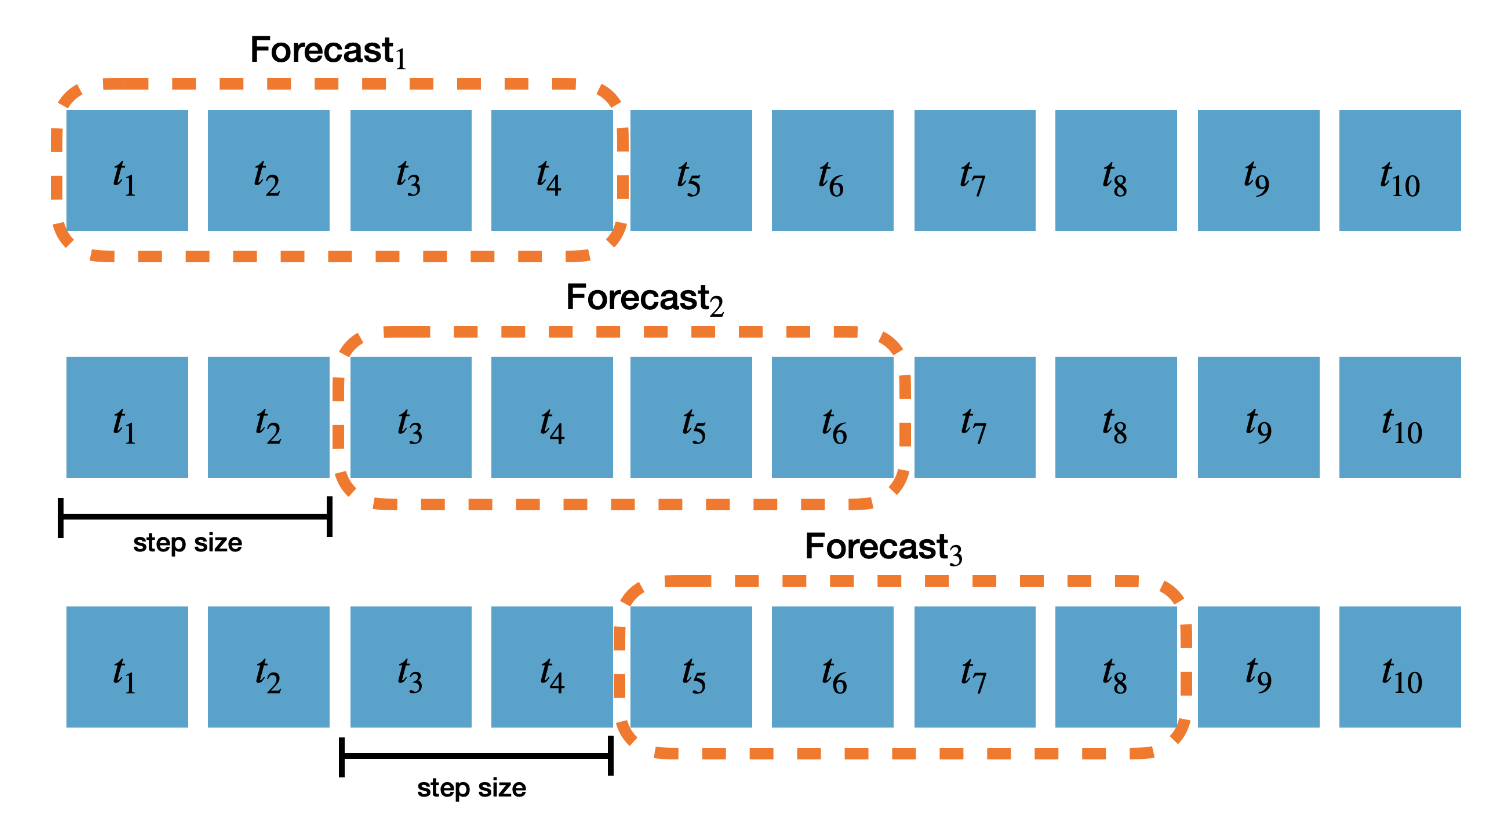

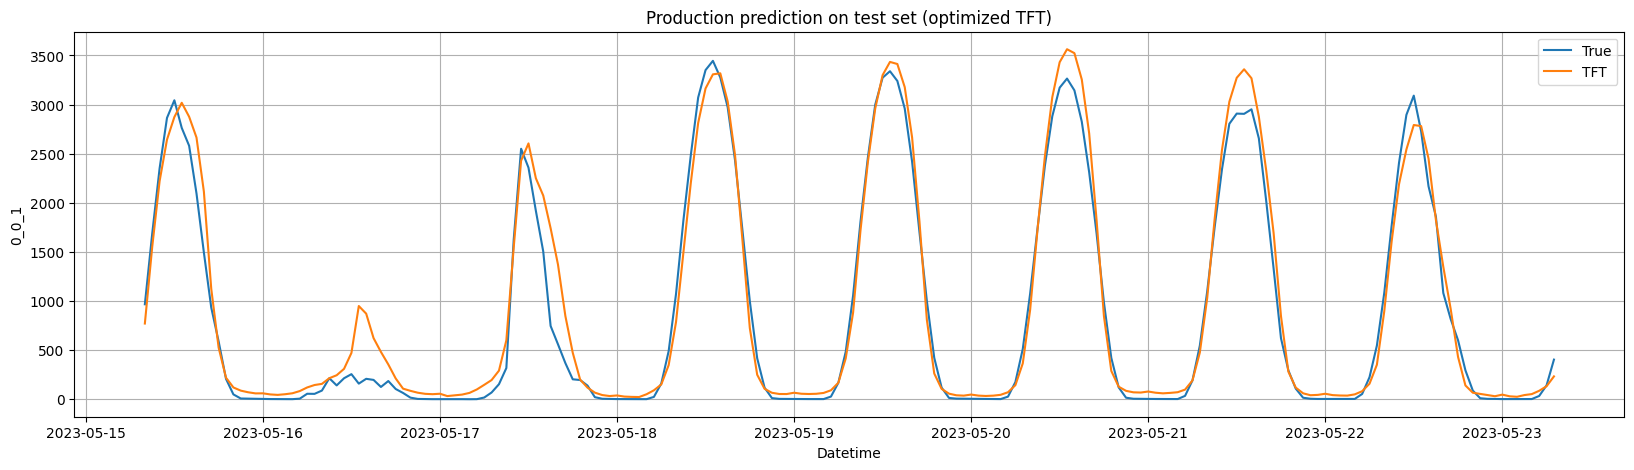

In [121]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Production prediction on test set (optimized TFT)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['TFT'], label='TFT')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('production_preds_optimized_TFT.png')
plt.show()

# Predict: imitation of a Kaggle submission

In [106]:
last_48_h = test.ds.unique()[-2*24:]
print('Time steps to predict: ', len(last_48_h))

lookback_h = test.ds.unique()[-study.best_trial.params['input_size']:-2*24]
print('Time steps lookback: ', len(lookback_h))

segments_to_predict = test[test['ds'].isin(last_48_h)]['unique_id']
print('Number of unique segments to predict:', segments_to_predict.nunique())
print('Number of total segments in df_test:', test['unique_id'].nunique())

Time steps to predict:  48
Time steps lookback:  183
Number of unique segments to predict: 62
Number of total segments in df_test: 62


In [107]:
segments_in_train_set = nf.uids

static_df = static_df[static_df['unique_id'].isin(segments_in_train_set)]
static_df = static_df.drop_duplicates()
print('Number of unique segments in static_df:', static_df['unique_id'].nunique())

df_test_lookback = test[test['ds'].isin(lookback_h)]
df_test_lookback = df_test_lookback[df_test_lookback['unique_id'].isin(segments_in_train_set)]

futr_df = test[test['ds'].isin(last_48_h)]
futr_df = futr_df[futr_df['unique_id'].isin(segments_in_train_set)]
print(f"Segments in futr_df: {futr_df['unique_id'].nunique()}")
futr_df = futr_df.drop(columns=["y"])

Number of unique segments in static_df: 62
Segments in futr_df: 62


In [108]:
Y_hat_df = nf.predict(df=df_test_lookback,
                      static_df=static_df,
                      futr_df=futr_df)

Predicting: 0it [00:00, ?it/s]

In [109]:
true_and_preds = test[test['ds'].isin(last_48_h)].merge(Y_hat_df, on=['ds','unique_id'])
true_and_preds = true_and_preds[['ds','unique_id','y','TFT']]

In [110]:
segment = '0_0_1'
plot_df = true_and_preds[true_and_preds['unique_id']==segment]
plot_df_lookback = df_test_lookback[df_test_lookback['unique_id']==segment]

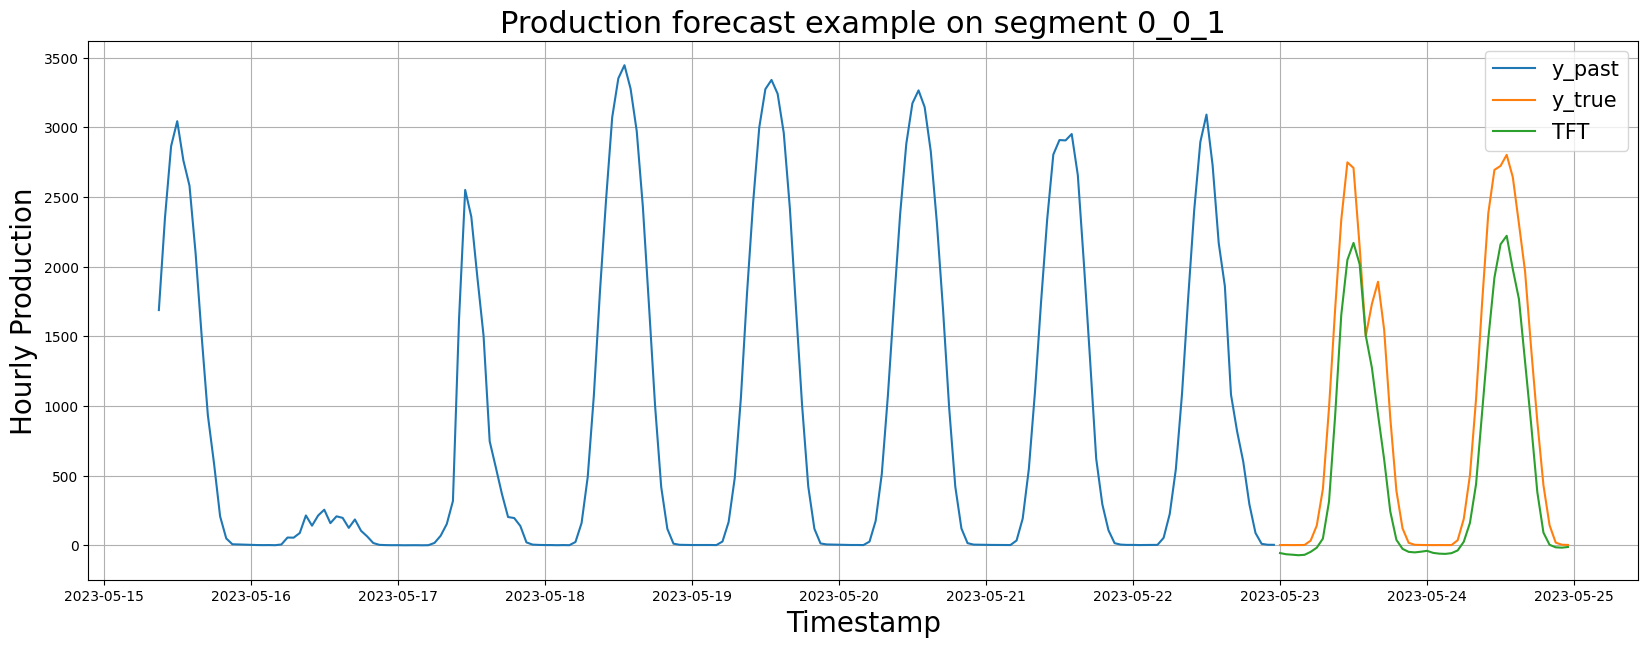

In [111]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(plot_df_lookback['ds'], plot_df_lookback['y'], label='y_past')
plt.plot(plot_df['ds'], plot_df['y'], label='y_true')
plt.plot(plot_df['ds'], plot_df['TFT'], label='TFT')

ax.set_title(f'Production forecast example on segment {segment}', fontsize=22)
ax.set_ylabel('Hourly Production', fontsize=20)
ax.set_xlabel('Timestamp', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [130]:
Y_hat_df.to_csv('Optimized_TFT_predictions.csv')

# Consumption

In [157]:
static = ["county", "is_business", "product_type"]
past_covariates = ["production","lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards",
                    "sin(dayofyear)","cos(dayofyear)", "sin(hour)", "cos(hour)", "is_country_holiday"]

In [158]:
import torch
import gc

In [164]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)

    hidden_size = trial.suggest_categorical("hidden_size", [16, 64, 80, 112, 128]) # Going higher than 128 will get cuda out of memory
    n_head = trial.suggest_categorical("n_head", [1, 4, 8]) # [4, 8] by default
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [128, 256, 512, 1024])
    drop_out_rate = trial.suggest_categorical("drop_out_rate",[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]) # Default is 0.1, not optimised in AutoTFT by default
    random_seed = trial.suggest_int("random_seed", 1, 20)

    models =  [TFT(h=output_size,
                   input_size=input_size,
                   stat_exog_list=static,
                   hist_exog_list=past_covariates,
                   futr_exog_list=future_covariates,
                   hidden_size=hidden_size,
                   n_head=n_head,
                   dropout=drop_out_rate,
                   loss=MAE(),
                   valid_loss=None,
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=random_seed)]

    n_time = len(train['datetime'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None,
                                  static_df=static_df.rename(columns={'segment':'unique_id'}))

    loss = mae(Y_hat_df['y'], Y_hat_df['TFT'])

    return loss if loss != np.nan else float("inf")

In [165]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-22 11:13:55,976] A new study created in memory with name: no-name-2ffadb11-bc30-4dd8-a2ff-9580cdb075d7
INFO:lightning_fabric.utilities.seed:Global seed set to 10


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 11:18:56,226] Trial 0 finished with value: 80.45454406738281 and parameters: {'input_size': 280, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.02343663985664673, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 10}. Best is trial 0 with value: 80.45454406738281.
INFO:lightning_fabric.utilities.seed:Global seed set to 17


Current value: 80.45454406738281, Current params: {'input_size': 280, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.02343663985664673, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 10}
Best value: 80.45454406738281, Best params: {'input_size': 280, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.02343663985664673, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 10}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 11:20:38,163] Trial 1 finished with value: 113.1116714477539 and parameters: {'input_size': 75, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 4.0265809009052845e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 17}. Best is trial 0 with value: 80.45454406738281.
INFO:lightning_fabric.utilities.seed:Global seed set to 11


Current value: 113.1116714477539, Current params: {'input_size': 75, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 4.0265809009052845e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 17}
Best value: 80.45454406738281, Best params: {'input_size': 280, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 0.02343663985664673, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 10}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 11:23:56,832] Trial 2 finished with value: 63.7415657043457 and parameters: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 15


Current value: 63.7415657043457, Current params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 11:38:34,406] Trial 3 finished with value: 361.78192138671875 and parameters: {'input_size': 244, 'hidden_size': 112, 'n_head': 8, 'learning_rate': 0.0001454551549561436, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 1024, 'drop_out_rate': 0.9, 'random_seed': 15}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 12


Current value: 361.78192138671875, Current params: {'input_size': 244, 'hidden_size': 112, 'n_head': 8, 'learning_rate': 0.0001454551549561436, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 1024, 'drop_out_rate': 0.9, 'random_seed': 15}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 11:50:26,783] Trial 4 finished with value: 364.81610107421875 and parameters: {'input_size': 194, 'hidden_size': 112, 'n_head': 1, 'learning_rate': 0.00011414207230584044, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.2, 'random_seed': 12}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 9


Current value: 364.81610107421875, Current params: {'input_size': 194, 'hidden_size': 112, 'n_head': 1, 'learning_rate': 0.00011414207230584044, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.2, 'random_seed': 12}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 11:59:49,805] Trial 5 finished with value: 134.40367126464844 and parameters: {'input_size': 265, 'hidden_size': 112, 'n_head': 4, 'learning_rate': 0.015726789985005173, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 9}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 18


Current value: 134.40367126464844, Current params: {'input_size': 265, 'hidden_size': 112, 'n_head': 4, 'learning_rate': 0.015726789985005173, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 9}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:04:57,136] Trial 6 finished with value: 101.0523452758789 and parameters: {'input_size': 90, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 1.7652623215122374e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.7, 'random_seed': 18}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 101.0523452758789, Current params: {'input_size': 90, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 1.7652623215122374e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.7, 'random_seed': 18}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:06:47,581] Trial 7 finished with value: 72.69578552246094 and parameters: {'input_size': 213, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.0016450353252826495, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.4, 'random_seed': 1}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 72.69578552246094, Current params: {'input_size': 213, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.0016450353252826495, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.4, 'random_seed': 1}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:11:59,544] Trial 8 finished with value: 374.2374572753906 and parameters: {'input_size': 325, 'hidden_size': 112, 'n_head': 4, 'learning_rate': 2.8044743609442452e-05, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.4, 'random_seed': 4}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 16


Current value: 374.2374572753906, Current params: {'input_size': 325, 'hidden_size': 112, 'n_head': 4, 'learning_rate': 2.8044743609442452e-05, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.4, 'random_seed': 4}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:13:19,205] Trial 9 finished with value: 92.22681427001953 and parameters: {'input_size': 254, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.0026900669624036295, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.4, 'random_seed': 16}. Best is trial 2 with value: 63.7415657043457.
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Current value: 92.22681427001953, Current params: {'input_size': 254, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 0.0026900669624036295, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 128, 'drop_out_rate': 0.4, 'random_seed': 16}
Best value: 63.7415657043457, Best params: {'input_size': 161, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.007887532674658098, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 11}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:15:03,283] Trial 10 finished with value: 60.3879280090332 and parameters: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Current value: 60.3879280090332, Current params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:16:50,022] Trial 11 finished with value: 68.29576110839844 and parameters: {'input_size': 147, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.00712542735547026, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 7


Current value: 68.29576110839844, Current params: {'input_size': 147, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.00712542735547026, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:17:36,708] Trial 12 finished with value: 133.24525451660156 and parameters: {'input_size': 138, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.06447218745656894, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 7}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 13


Current value: 133.24525451660156, Current params: {'input_size': 138, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.06447218745656894, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 7}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:19:58,644] Trial 13 finished with value: 68.27360534667969 and parameters: {'input_size': 150, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.0004478041177337815, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 13}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 20


Current value: 68.27360534667969, Current params: {'input_size': 150, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.0004478041177337815, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 13}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:21:06,148] Trial 14 finished with value: 70.71209716796875 and parameters: {'input_size': 184, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.005201221262424346, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 20}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 70.71209716796875, Current params: {'input_size': 184, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.005201221262424346, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 20}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:23:14,028] Trial 15 finished with value: 77.66937255859375 and parameters: {'input_size': 110, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.00043126645878766425, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 4}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 9


Current value: 77.66937255859375, Current params: {'input_size': 110, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.00043126645878766425, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 256, 'drop_out_rate': 0.2, 'random_seed': 4}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:25:08,124] Trial 16 finished with value: 103.29815673828125 and parameters: {'input_size': 170, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.09879829818265878, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 9}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 103.29815673828125, Current params: {'input_size': 170, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.09879829818265878, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 9}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:26:48,447] Trial 17 finished with value: 75.38760375976562 and parameters: {'input_size': 115, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.021005861947511917, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.7, 'random_seed': 1}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 7


Current value: 75.38760375976562, Current params: {'input_size': 115, 'hidden_size': 16, 'n_head': 4, 'learning_rate': 0.021005861947511917, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.7, 'random_seed': 1}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:27:58,713] Trial 18 finished with value: 74.99685668945312 and parameters: {'input_size': 220, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.0007737691517668044, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 7}. Best is trial 10 with value: 60.3879280090332.
INFO:lightning_fabric.utilities.seed:Global seed set to 12


Current value: 74.99685668945312, Current params: {'input_size': 220, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.0007737691517668044, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 7}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 12:29:49,262] Trial 19 finished with value: 61.25048828125 and parameters: {'input_size': 121, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.005198158025495793, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.5, 'random_seed': 12}. Best is trial 10 with value: 60.3879280090332.


Current value: 61.25048828125, Current params: {'input_size': 121, 'hidden_size': 80, 'n_head': 4, 'learning_rate': 0.005198158025495793, 'scaler_type': 'robust', 'batch_size': 16, 'windows_batch_size': 512, 'drop_out_rate': 0.5, 'random_seed': 12}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}
Best value: 60.3879280090332, Best params: {'input_size': 141, 'hidden_size': 80, 'n_head': 1, 'learning_rate': 0.005757354854933934, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.1, 'random_seed': 6}


In [166]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [175]:
study.best_trial.params

{'input_size': 141,
 'hidden_size': 80,
 'n_head': 1,
 'learning_rate': 0.005757354854933934,
 'scaler_type': 'standard',
 'batch_size': 32,
 'windows_batch_size': 256,
 'drop_out_rate': 0.1,
 'random_seed': 6}

In [169]:
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models = [TFT(h=2*24,
              input_size=study.best_trial.params['input_size'],
              hidden_size=study.best_trial.params['hidden_size'],
              n_head=study.best_trial.params['n_head'],
              learning_rate=study.best_trial.params['learning_rate'],
              scaler_type=study.best_trial.params['scaler_type'],
              batch_size=study.best_trial.params['batch_size'],
              windows_batch_size=study.best_trial.params['windows_batch_size'],
              dropout=study.best_trial.params['drop_out_rate'],
              random_seed=study.best_trial.params['random_seed'],
              stat_exog_list=static,
              hist_exog_list=past_covariates,
              futr_exog_list=future_covariates,
              loss=MAE(),
              valid_loss=None,
              max_steps=5000, # 1000 is the default
              val_check_steps=50, # 100 is the default
              early_stop_patience_steps=3)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf_consumption = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf_consumption.cross_validation(df=df_train.rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 6


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [170]:
mae_TFT_c = mae(Y_hat_df['y'], Y_hat_df['TFT'])
mae_TFT_c

70.13246

In [174]:
(mae_TFT_c + mae_TFT) / 2

82.45842742919922

In [171]:
Y_hat_df = Y_hat_df.reset_index()

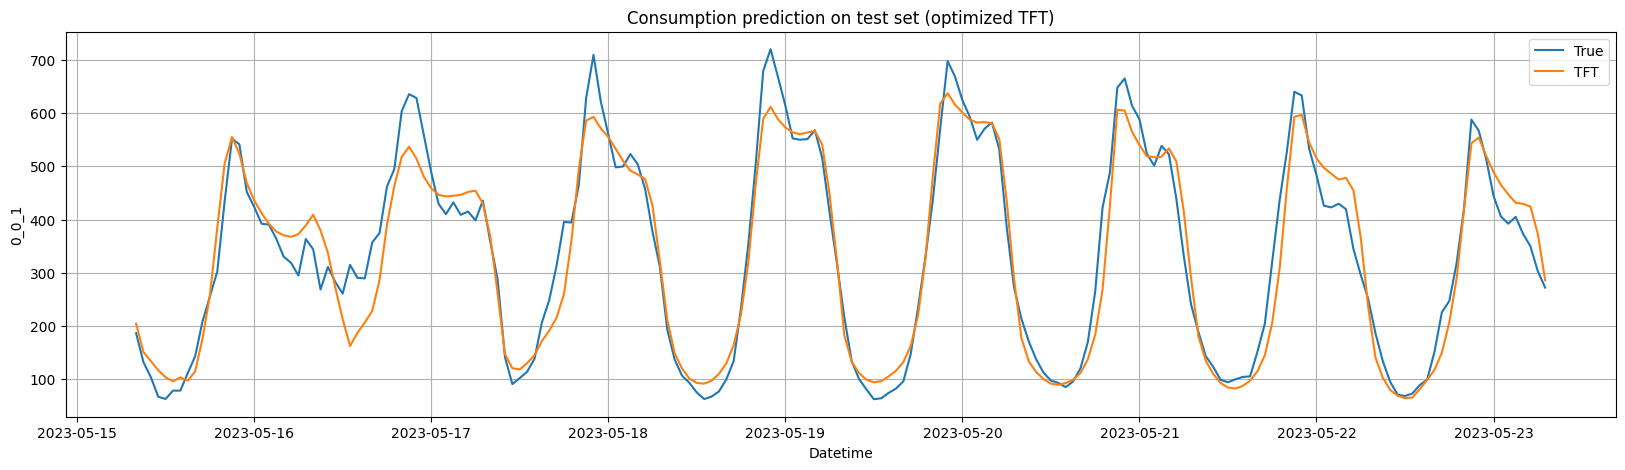

In [172]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Consumption prediction on test set (optimized TFT)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['TFT'], label='TFT')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('consumption_preds_optimized_TFT.png')
plt.show()